In [1]:
import json
from typing import List, Dict, Any

def build_storyboard(reports: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Converts multiple 'report' JSON objects into a single storyboard JSON,
    with these modifications:
      1) Removes "ScaleSelectors" components
      2) Renames component IDs by prefixing the page number (C1 -> P1C1).
    """

    if not reports:
        # Edge case: if empty, return a minimal structure
        return {"POV": [], "numberFormat": {}, "sections": [], "lists": {}}

    # 1) POV and numberFormat from the first report
    storyboard = {
        "POV": reports[0].get("POV", []),
        "numberFormat": reports[0].get("numberFormat", {}),
        "sections": [],
        "lists": {}
    }

    # Helper function: recursively rename IDs & remove ScaleSelectors
    def rename_and_filter_rows(rows: List[Dict[str, Any]], page_number: int):
        """
        In-place:
          - Skips (removes) any component whose type == "ScaleSelectors"
          - Renames 'id' -> f"P{page_number}{old_id}"
          - Recursively processes NestedRow -> config.rows
        """
        for row in rows:
            columns = row.get("columns", [])
            for col in columns:
                new_components = []
                for comp in col.get("components", []):
                    # 1) Skip ScaleSelectors
                    if comp.get("type") == "ScaleSelectors":
                        continue
                    # 2) Rename the 'id' if present
                    if "id" in comp:
                        old_id = comp["id"]
                        comp["id"] = f"P{page_number}{old_id}"
                    # 3) If NestedRow, recurse into its config.rows
                    if comp.get("type") == "NestedRow":
                        subrows = comp.get("config", {}).get("rows", [])
                        rename_and_filter_rows(subrows, page_number)
                    new_components.append(comp)
                col["components"] = new_components

    # 2) For each report in the list
    for i, r in enumerate(reports):
        page_number = i + 1  # 1-based page numbering

        # (a) Make a Header row for the reportTitle
        header_section = {
            "type": "Row",
            "gridColumns": {
                "sm": 8,
                "md": 8,
                "lg": 8
            },
            "columns": [
                {
                    "colSpan": {
                        "sm": 8,
                        "md": 8,
                        "lg": 8
                    },
                    "components": [
                        {
                            "type": "Header",
                            "content": r.get("reportTitle", "Untitled Report"),
                            "align": "left"
                        }
                    ]
                }
            ]
        }
        storyboard["sections"].append(header_section)

        # (b) Copy the rows from the report into the storyboard
        layout = r.get("layout", {})
        grid_cols = layout.get("gridColumns", {"sm": 8, "md": 8, "lg": 8})
        rows = layout.get("rows", [])

        # Rename IDs and remove ScaleSelectors before adding them
        rename_and_filter_rows(rows, page_number)

        for row in rows:
            new_section = {
                "type": "Row",
                "gridColumns": grid_cols,
                "columns": row.get("columns", [])
            }
            storyboard["sections"].append(new_section)

        # (c) Add a pagebreak after each report
        storyboard["sections"].append({"type": "PageBreak"})

        # (d) Gather the lists from this report
        report_lists = r.get("lists", {})
        for list_key, list_val in report_lists.items():
            # If there's a collision in list keys, you can decide whether to overwrite or skip
            if list_key not in storyboard["lists"]:
                storyboard["lists"][list_key] = list_val
            else:
                # Overwrite or skip? Here we skip if it already exists
                pass

    return storyboard


In [ ]:
from CFOLytics_reportgenerator import app
from typing_extensions import TypedDict
from typing import Optional, TypedDict, List, Dict, Any, Union
from typing import Annotated
import operator
from langgraph.graph import StateGraph, START, END
from langgraph.constants import Send

class StoryBoardState(TypedDict):
    pages: List[Dict[str, Any]]
    POV: Annotated[List[dict], operator.add]
    ReportMetadata: Annotated[List[Dict[str, Any]], operator.add]
    ExistingLists: Annotated[List[dict], operator.add]
    JsonLayoutList: Annotated[List[Dict[str, Any]], operator.add]
    final_storyboard_json : List[Dict[str, Any]]

def parse_pages(state: StoryBoardState):
    return {"pages": state["pages"]}

def consolidate_json(state: StoryBoardState):
    return {"final_storyboard_json": build_storyboard(state["JsonLayoutList"])}

def continue_to_reports(state: StoryBoardState):
    sends = []
    for page in state["pages"]:
        # 'instructions' => 'ReportQuery'
        payload = {
            "ReportQuery": page["instructions"],
            "POV": state["POV"],
            "ReportMetadata": state["ReportMetadata"],
            "ExistingLists": state["ExistingLists"]
            # ... add more if needed
        }
        sends.append(Send("generate_report_subgraph", payload))
    return sends




sbgraph = StateGraph(StoryBoardState)

sbgraph.add_node("parse_pages", parse_pages)
sbgraph.add_node("generate_report_subgraph", app)
sbgraph.add_node("consolidate_json", consolidate_json)


sbgraph.add_edge(START, "parse_pages")

sbgraph.add_conditional_edges("parse_pages", continue_to_reports, ["generate_report_subgraph"])

sbgraph.add_edge("generate_report_subgraph", "consolidate_json")
sbgraph.add_edge("consolidate_json", END)

sbapp = sbgraph.compile()





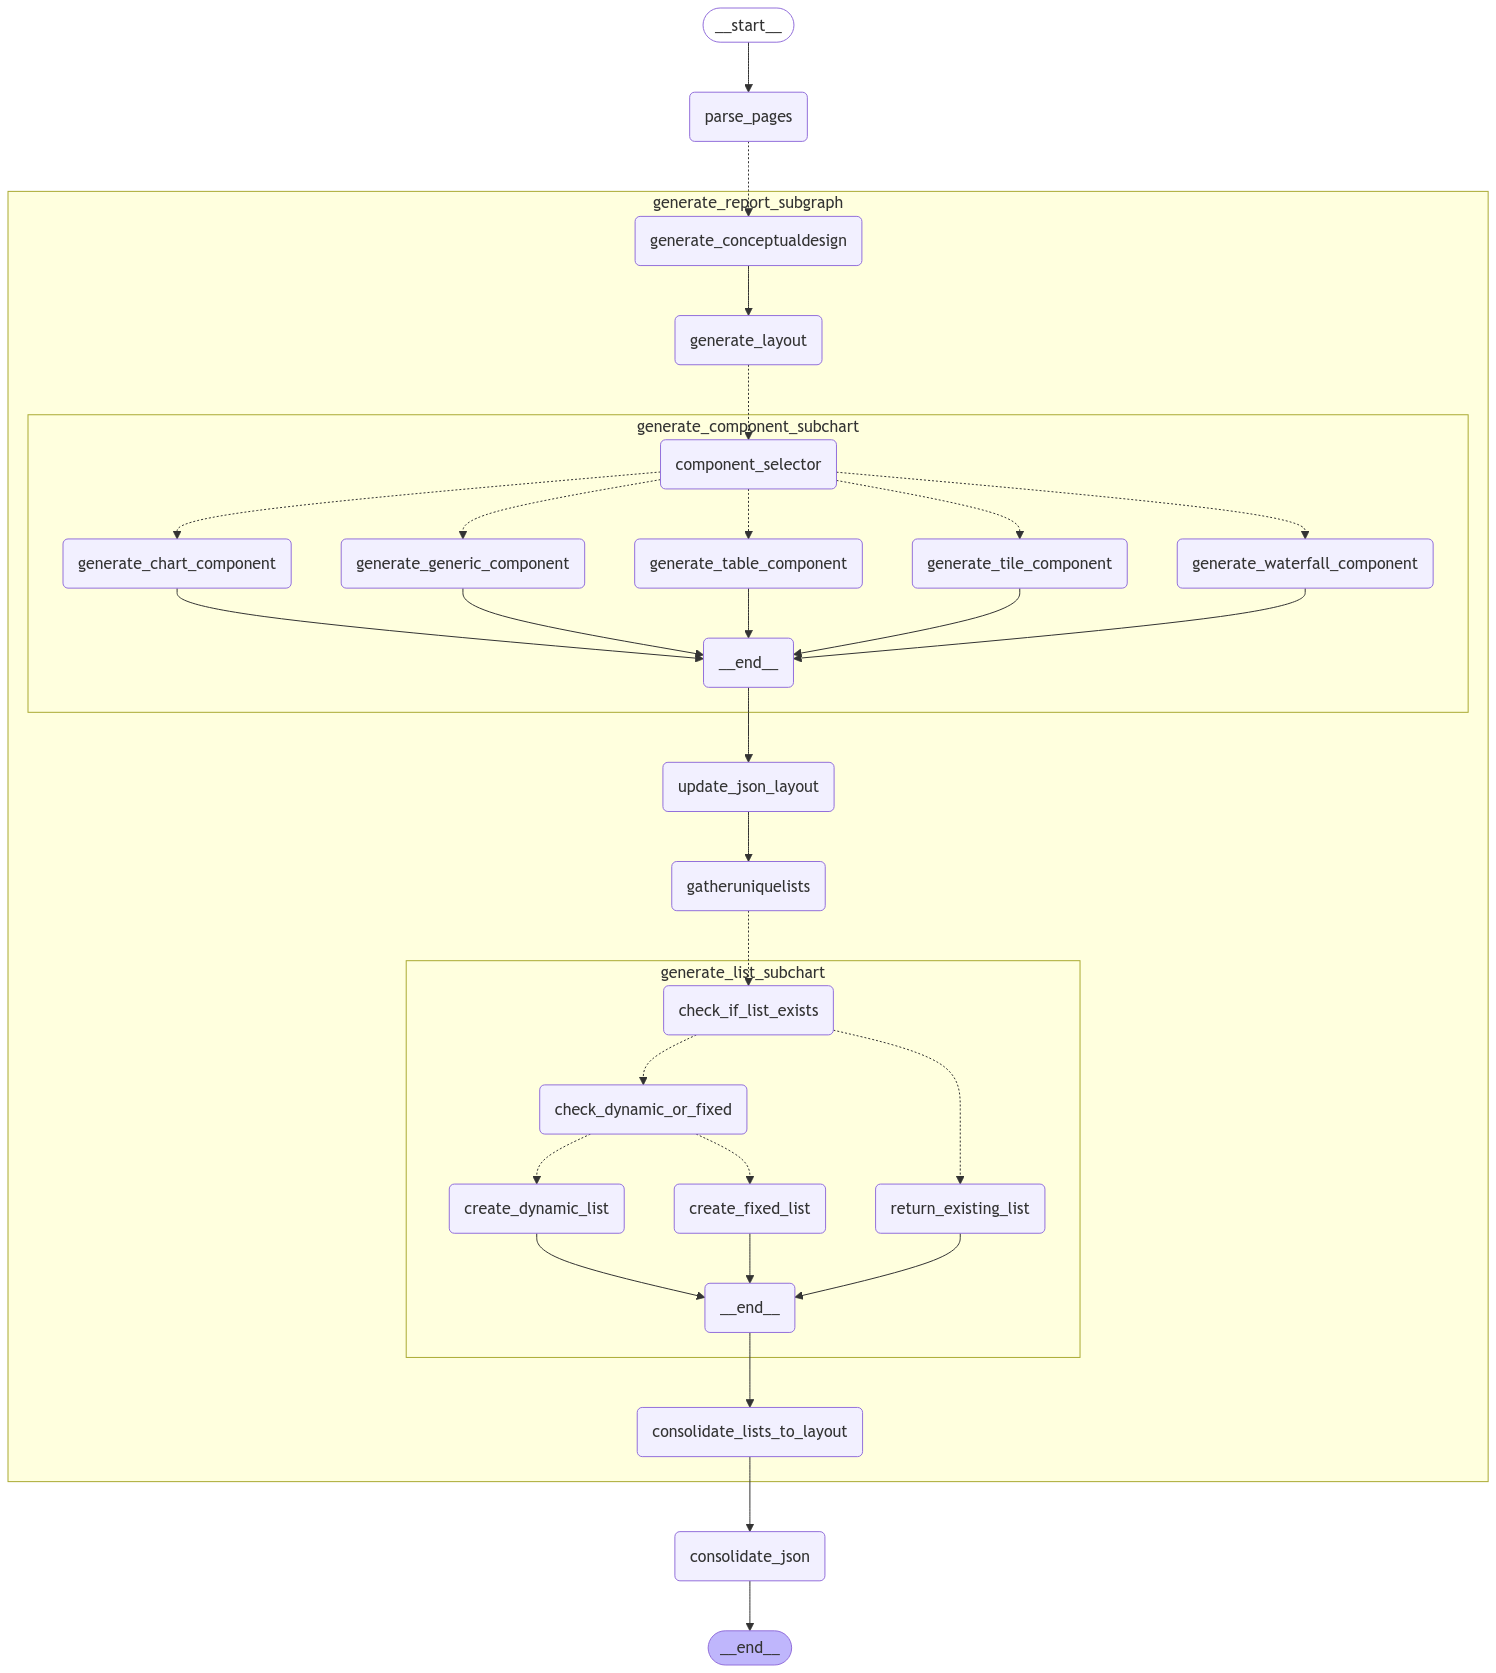

In [3]:
from IPython.display import Image
Image(sbapp.get_graph(xray=2).draw_mermaid_png())

In [4]:
import json
from typing import Annotated, List


with open("sb_sample.json", "r", encoding="utf-8") as f:
    state_data = json.load(f)

state = StoryBoardState(state_data)
result_state = sbapp.invoke(state)

final_json = json.dumps(result_state["final_storyboard_json"], ensure_ascii=False, separators=(",", ":")).replace("True", "true").replace("False", "false")

print(final_json)

[{"name":"Account","alias":"Account","dimensionContent":[{"ID":1059,"Name":"Depreciation IFRS16","ParentID":null},{"ID":1060,"Name":"Interest on term loan","ParentID":1332},{"ID":1061,"Name":"Foreign exchange gain/loss","ParentID":1332},{"ID":1062,"Name":"Other cost of goods sold","ParentID":1333},{"ID":1063,"Name":"Others","ParentID":1330},{"ID":1064,"Name":"Depreciation","ParentID":1332},{"ID":1065,"Name":"General Office Supplies","ParentID":1330},{"ID":1066,"Name":"Advertising and marketing","ParentID":1331},{"ID":1067,"Name":"Delivery expenses - Fulfillment Cost ","ParentID":1325},{"ID":1068,"Name":"Insurance","ParentID":1329},{"ID":1069,"Name":"Internet and Phone","ParentID":1330},{"ID":1070,"Name":"Service Charges","ParentID":1329},{"ID":1071,"Name":"Discounts","ParentID":1323},{"ID":1072,"Name":"Direct Staff costs others","ParentID":1333},{"ID":1073,"Name":"Rent - IFRS16","ParentID":null},{"ID":1074,"Name":"Interest on term loan - IFRS16","ParentID":null},{"ID":1075,"Name":"Aggr

In [5]:
reportList = result_state["JsonLayoutList"]
print(build_storyboard(reportList))

{'POV': [{'Top': None, 'Name': 'Entity', 'Alias': 'Entity', 'InUse': True, 'Order': 0, 'Default': 'The Petshop', 'Visible': True}, {'Top': None, 'Name': 'Category', 'Alias': 'Category', 'InUse': True, 'Order': 2, 'Default': 'Actual', 'Visible': False}, {'Top': None, 'Name': 'Year', 'Alias': 'Year', 'InUse': True, 'Order': 3, 'Default': '2024', 'Visible': True}, {'Top': None, 'Name': 'Period', 'Alias': 'Period', 'InUse': True, 'Order': 4, 'Default': 'Dec', 'Visible': True}, {'Top': None, 'Name': 'View', 'Alias': 'View', 'InUse': True, 'Order': 5, 'Default': 'Periodic', 'Visible': True}, {'Top': None, 'Name': 'Account', 'Alias': 'Account', 'InUse': True, 'Order': 6, 'Default': 'Gross Sales', 'Visible': False}, {'Top': None, 'Name': 'AnalyticalDim1', 'Alias': 'Cost Center', 'InUse': True, 'Order': 7, 'Default': 'Top', 'Visible': False}, {'Top': None, 'Name': 'AnalyticalDim2', 'Alias': 'Channel', 'InUse': True, 'Order': 8, 'Default': 'Top', 'Visible': False}, {'Top': None, 'Name': 'Analyti